<a href="https://colab.research.google.com/github/timothy2077/1st-Rep/blob/master/Exploration_Project_G_082924.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

..0# 14-1. 프로젝트: 이제까지 만들었던 모델을 튜닝하고 배포하기!

In [ ]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
!curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
/bin/bash: line 1: !curl: command not found
gpg: no valid OpenPGP data found.


# 0. 모델 고정해서 사용하기

## 하기 모델은 CIFAR-10 데이터셋의 이미지 분류를 위해 설계되었으며, 이미지에 표시된 아키텍처를 반영하도록 하자

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 모델 생성
model = models.Sequential()

# 첫 번째 컨볼루션 레이어
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 두 번째 컨볼루션 레이어
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 컨볼루션 레이어의 출력을 평탄화
model.add(layers.Flatten())

# 완전 연결층
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # 정규화를 위한 드롭아웃

# CIFAR-10 분류를 위한 출력층
model.add(layers.Dense(10, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 15, 15, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 15, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 6, 6, 64)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 612,426 (2.34 MB)

 Trainable params: 612,234 (2.34 MB)

 Non-trainable params: 192 (768.00 B)

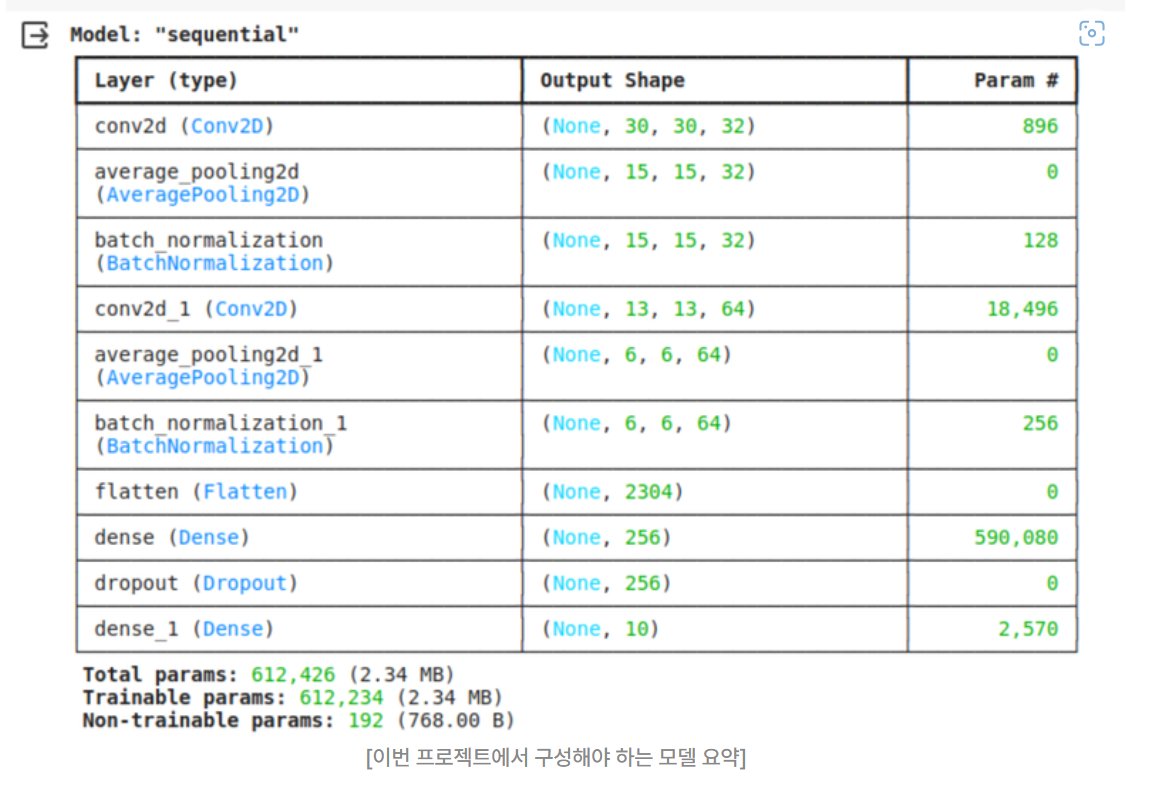

## 모델의 구성:

### Conv2D 레이어: 이 레이어는 3x3 커널 크기와 ReLU 활성화를 사용하여 합성곱 연산을 수행
### AveragePooling2D: 2x2 윈도우에서 평균을 취해 공간 차원을 감소
### BatchNormalization: 출력을 정규화하여 학습을 안정화하고 가속화
### Flatten: 2D 행렬 데이터를 완전 연결층을 위해 1D 벡터로 변환
### Dense: 첫 번째 Dense 레이어는 256개의 유닛을 가지고 있으며, 마지막 출력 레이어는 CIFAR-10 분류를 위해 10개의 유닛 보유
### Dropout: 학습 중 일부 입력 유닛을 0으로 설정하여 과적합을 방지하는 정규화 기법
### 출력층: 소프트맥스 활성화를 사용하여 클래스 확률을 출력



# 1. Data Centric AI 맛보기

## A. 구현된 모델 사용 없이 이미지 레이블의 정확성을 확인하고 잘못된 레이블을 수정하기

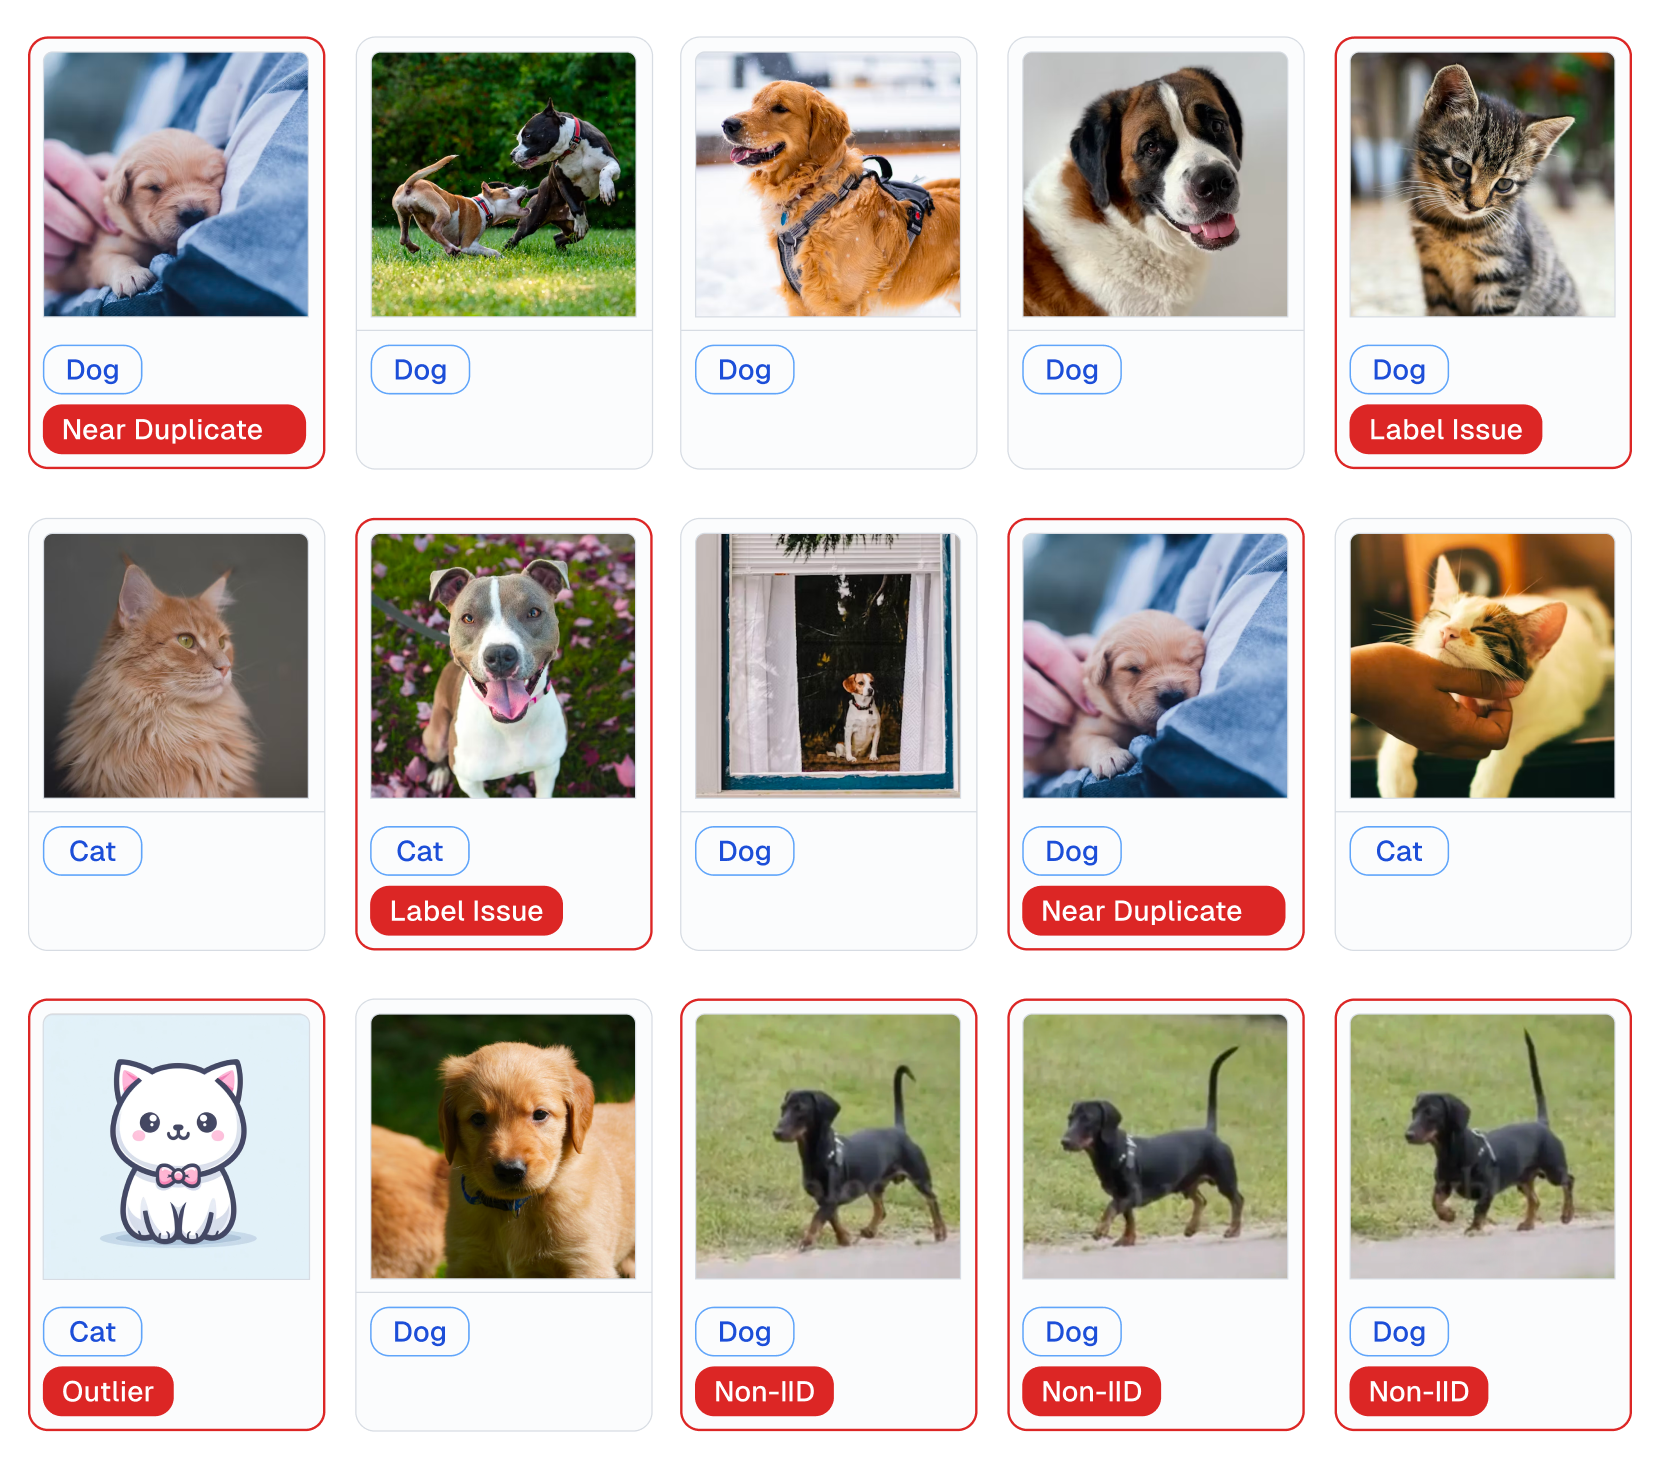

In [ ]:
pip install matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48660 (\N{HANGUL SYLLABLE BEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


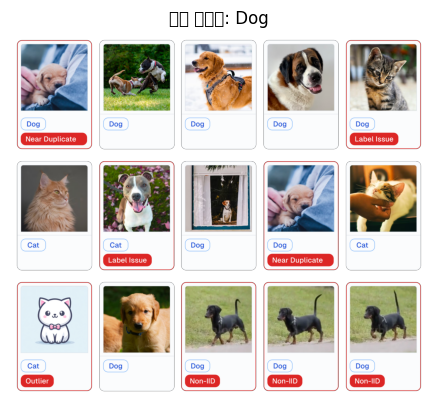

KeyboardInterrupt: Interrupted by user

In [ ]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# 이미지의 URL
image_url = 'https://raw.githubusercontent.com/cleanlab/assets/master/cleanlab/datalab_issues.png'
log_file_path = '/mnt/data/relabel_log.txt'  # 변경 사항을 추적하는 로그 파일

# 이미지 파일 이름을 현재 레이블에 매핑하는 사전
image_labels = {
    'image1': 'Dog',   # 예시, 실제 파일 이름으로 업데이트하세요
    'image2': 'Cat',
    # 여기에 모든 이미지와 현재 레이블을 추가하세요
}

# URL에서 이미지를 다운로드하고 표시하는 함수
def inspect_and_relabel_image(image_url, current_label):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # 이미지를 표시
    plt.imshow(img)
    plt.title(f'현재 레이블: {current_label}')
    plt.axis('off')
    plt.show()

    # 사용자가 레이블이 올바른지 또는 변경이 필요한지 묻기
    new_label = input(f"이 이미지의 새 레이블을 입력하세요 (현재 레이블 '{current_label}'를 유지하려면 Enter 키를 누르세요): ").strip()

    # 사용자가 새 레이블을 제공하면 레이블 업데이트
    if new_label and new_label != current_label:
        return new_label
    return current_label

# 변경 사항을 기록하는 함수
def log_change(image_name, old_label, new_label):
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"이미지: {image_name}, 이전 레이블: {old_label}, 새 레이블: {new_label}\n")

# 이미지를 검사하고 레이블을 변경하는 메인 루프
for image_name, current_label in image_labels.items():

    # 시각적 검사 및 선택적 레이블 변경
    new_label = inspect_and_relabel_image(image_url, current_label)

    # 레이블이 변경된 경우 변경 사항 기록
    if new_label != current_label:
        log_change(image_name, current_label, new_label)

print("레이블 검사 및 변경이 완료되었습니다.")



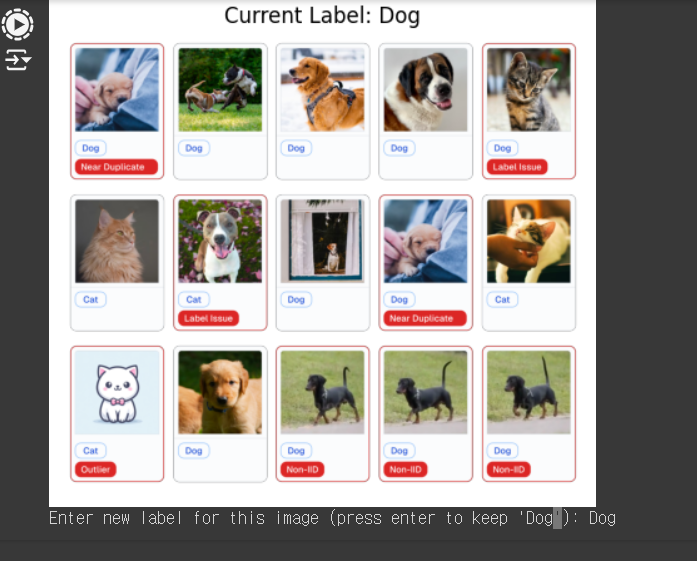

## Process:

### 1. 이미지 다운로드 및 표시:
#### inspect_and_relabel_image 함수를 사용하여 주어진 URL에서 이미지를 다운로드하고 표시한 후 사용자가 현재 레이블을 확인하고, 필요시 새로운 레이블을 입력할 수 있도록 만들자
### 2. 레이블 변경 기록:
#### log_change 함수는 레이블이 변경된 경우, 변경 사항을 로그 파일에 기록하자
### 3. 메인 루프:
#### image_labels 사전에 있는 모든 이미지에 대해 시각적 검사를 수행하고, 필요시 레이블을 변경하고, 레이블이 변경된 경우, 변경 사항을 로그 파일에 기록하자

## B. 구현된 모델을 베이스로 이미지 레이블의 정확성을 확인하고 잘못된 레이블을 수정하기 (Trial 1)

### 1. 이미지 변환: convert('RGB')를 추가하여 이미지가 RGB 모드로 변환하는 단계를 거쳐이미지 형식이 예상된 형식이 아닐 수 있는 경우 오류를 방지하도록 하자

### 2. 에러 처리: try-except 블록을 추가하여 UnidentifiedImageError를 처리하고, 이미지를 처리할 수 없는 경우 의미 있는 메시지를 출력하자

### 3. 정규화: 이미지 픽셀 값을 255.0으로 나누어 정규화하여 모델 예측에 적합하도록 만들자



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48660 (\N{HANGUL SYLLABLE BEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

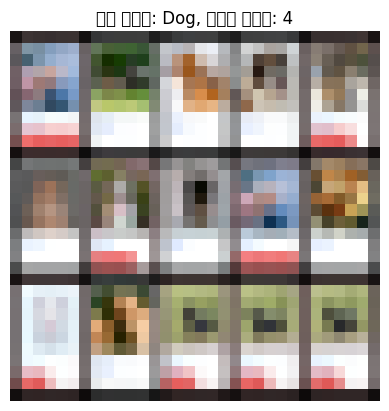

이 이미지의 새 레이블을 입력하세요 (현재 레이블 'Dog'를 유지하려면 Enter 키를 누르세요): 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


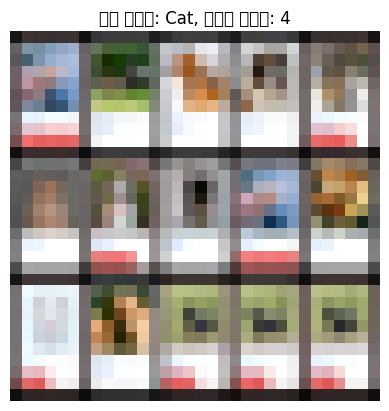

이 이미지의 새 레이블을 입력하세요 (현재 레이블 'Cat'를 유지하려면 Enter 키를 누르세요): 
레이블 검사 및 변경이 완료되었습니다.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import numpy as np

# CIFAR-10 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 이미지 URL
image_url = 'https://raw.githubusercontent.com/cleanlab/assets/master/cleanlab/datalab_issues.png'
log_file_path = '/mnt/data/relabel_log.txt'  # 변경 사항을 추적하는 로그 파일

# 이미지 파일 이름을 현재 레이블에 매핑하는 사전
image_labels = {
    'image1': 'Dog',  # 예시, 실제 파일 이름으로 업데이트
    'image2': 'Cat',
    # 여기에 모든 이미지와 현재 레이블 추가
}

# URL에서 이미지를 다운로드하고 배열로 변환하는 함수
def fetch_image_array(image_url):
    response = requests.get(image_url)
    try:
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')  # Ensure the image is in RGB mode
        img = img.resize((32, 32))  # Resize to match CIFAR-10 input size
        img_array = np.array(img) / 255.0  # Normalize pixel values
        return img_array
    except UnidentifiedImageError as e:
        print(f"Error loading image from {image_url}: {e}")
        return None

# 모델을 사용하여 이미지의 레이블 예측과 검사
def inspect_and_relabel_image(image_url, current_label):
    # 이미지를 가져와 배열로 변환
    img_array = fetch_image_array(image_url)
    if img_array is None:
        print("이미지를 처리할 수 없습니다.")
        return current_label  # If the image couldn't be processed, keep the current label

    # 모델을 사용하여 레이블 예측
    prediction = model.predict(np.expand_dims(img_array, axis=0))
    predicted_label = np.argmax(prediction)

    # 현재 레이블과 예측된 레이블 비교
    plt.imshow(img_array)
    plt.title(f'현재 레이블: {current_label}, 예측된 레이블: {predicted_label}')
    plt.axis('off')
    plt.show()

    # 사용자가 레이블이 올바른지 또는 변경이 필요한지 묻기
    new_label = input(f"이 이미지의 새 레이블을 입력하세요 (현재 레이블 '{current_label}'를 유지하려면 Enter 키를 누르세요): ").strip()

    # 사용자가 새 레이블을 제공하면 레이블 업데이트
    if new_label and new_label != current_label:
        return new_label
    return current_label

# 변경 사항을 기록하는 함수
def log_change(image_name, old_label, new_label):
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"이미지: {image_name}, 이전 레이블: {old_label}, 새 레이블: {new_label}\n")

# 이미지를 검사하고 레이블을 변경하는 메인 루프
for image_name, current_label in image_labels.items():

    # 시각적 검사 및 선택적 레이블 변경
    new_label = inspect_and_relabel_image(image_url, current_label)

    # 레이블이 변경된 경우 변경 사항 기록
    if new_label != current_label:
        log_change(image_name, current_label, new_label)

print("레이블 검사 및 변경이 완료되었습니다.")


## C. 구현된 모델을 베이스로 이미지 레이블의 정확성을 확인하고 잘못된 레이블 수정하기(Trial 2)

### !. Figure Size (plt.figure(figsize=(8, 8))): 이미지 크기를 더 크게 하고 명확하게 표시하기 위해 figure의 크기를 늘림

### 2. Interpolation (interpolation='nearest'): 이미지를 더 선명하게 표시하기 위해 보간 방법을 'nearest'로 설정

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


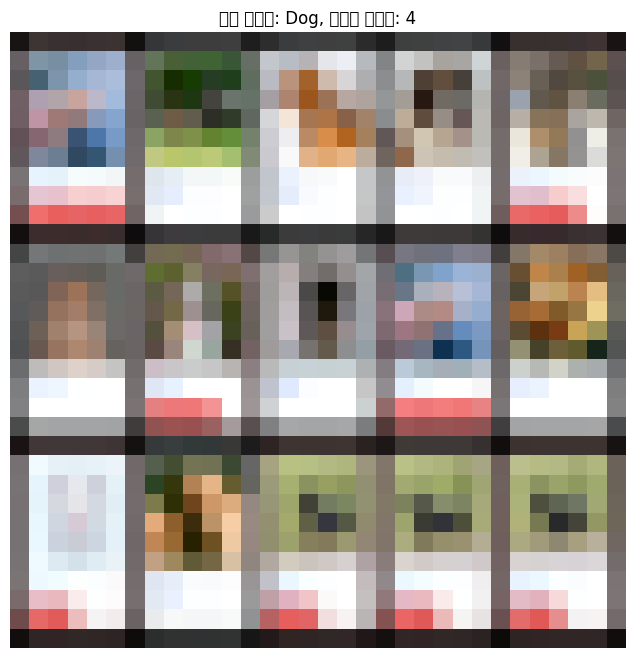

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import numpy as np

# CIFAR-10 모델 구성 (이전 코드 사용)

# 이미지 URL
image_url = 'https://raw.githubusercontent.com/cleanlab/assets/master/cleanlab/datalab_issues.png'
log_file_path = '/mnt/data/relabel_log.txt'

# 이미지 파일 이름을 현재 레이블에 매핑하는 사전
image_labels = {
    'image1': 'Dog',  # 예시, 실제 파일 이름으로 업데이트
    'image2': 'Cat',
}

# URL에서 이미지를 다운로드하고 배열로 변환하는 함수
def fetch_image_array(image_url):
    response = requests.get(image_url)
    try:
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')  # RGB 모드로 변환
        img = img.resize((32, 32))  # CIFAR-10 크기로 리사이즈
        img_array = np.array(img) / 255.0  # 정규화
        return img_array
    except UnidentifiedImageError as e:
        print(f"Error loading image from {image_url}: {e}")
        return None

# 모델을 사용하여 이미지의 레이블 예측과 검사
def inspect_and_relabel_image(image_url, current_label):
    # 이미지를 가져와 배열로 변환
    img_array = fetch_image_array(image_url)
    if img_array is None:
        print("이미지를 처리할 수 없습니다.")
        return current_label

    # 모델을 사용하여 레이블 예측
    prediction = model.predict(np.expand_dims(img_array, axis=0))
    predicted_label = np.argmax(prediction)

    # 현재 레이블과 예측된 레이블 비교 및 이미지 표시
    plt.figure(figsize=(8, 8))  # 이미지 크기 증가
    plt.imshow(img_array, interpolation='nearest')  # 선명하게 표시
    plt.title(f'현재 레이블: {current_label}, 예측된 레이블: {predicted_label}')
    plt.axis('off')
    plt.show()

    # 사용자에게 레이블 수정 여부 확인
    new_label = input(f"이 이미지의 새 레이블을 입력하세요 (현재 레이블 '{current_label}'를 유지하려면 Enter 키를 누르세요): ").strip()

    # 새 레이블이 제공되면 업데이트
    if new_label and new_label != current_label:
        return new_label
    return current_label

# 변경 사항을 기록하는 함수
def log_change(image_name, old_label, new_label):
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"이미지: {image_name}, 이전 레이블: {old_label}, 새 레이블: {new_label}\n")

# 이미지를 검사하고 레이블을 변경하는 메인 루프
for image_name, current_label in image_labels.items():
    new_label = inspect_and_relabel_image(image_url, current_label)

    if new_label != current_label:
        log_change(image_name, current_label, new_label)

print("레이블 검사 및 변경이 완료되었습니다.")


# 2. 하이퍼파라미터 튜닝

## A. 하이퍼파라미터 튜닝 (1st Trial)_Model A
### 1. 위에 있는 0(제로) 모델을 기반으로 KerasTuner로 하이퍼파라미터 튜닝을 진행합니다.
### 2.  튜닝한 하이퍼 파라미터로 학습을 진행하고 모델을 SavedModel 형식으로 저장해주세요.

## Process:

### 모델 학습: model.fit 함수를 사용해 CIFAR-10 데이터셋에서 모델을 10 에포크 동안 학습시키자

### 모델 평가: model.evaluate 함수를 사용해 학습된 모델을 테스트 데이터셋에서 평가하고 최종 테스트 정확도를 출력하자

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# CIFAR-10 데이터셋 로드 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 정규화 (0~1 사이로 스케일링)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 레이블을 원-핫 인코딩
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 모델 생성
model = models.Sequential()

# 첫 번째 컨볼루션 레이어
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 두 번째 컨볼루션 레이어
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 평탄화
model.add(layers.Flatten())

# 완전 연결층
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # 정규화를 위한 드롭아웃

# CIFAR-10 분류를 위한 출력층
model.add(layers.Dense(10, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

# 테스트 데이터셋을 사용하여 모델 평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 정확도: {test_acc:.4f}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.3879 - loss: 2.0179 - val_accuracy: 0.5381 - val_loss: 1.3532
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5995 - loss: 1.1356 - val_accuracy: 0.6006 - val_loss: 1.1601
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 79ms/step - accuracy: 0.6654 - loss: 0.9556 - val_accuracy: 0.6558 - val_loss: 0.9805
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.7023 - loss: 0.8507 - val_accuracy: 0.6696 - val_loss: 0.9477
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.7387 - loss: 0.7433 - val_accuracy: 0.6744 - val_loss: 0.9721
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 78ms/step - accuracy: 0.7634 - loss: 0.6713 - val_accuracy: 0.7013 - val_loss: 0.8833
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 78s 73ms/step - accuracy: 0.7894 - loss: 0.6033 - val_accuracy: 0.7121 - val_loss: 0.8411
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.8054 - loss: 0.5482 - 

## B. 하이퍼파라미터 튜닝 (2nd Trial)_Model B

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CIFAR-10 데이터셋 로드 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 정규화 (0~1 사이로 스케일링)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# 레이블을 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# 모델 생성
model = models.Sequential()

# 첫 번째 컨볼루션 레이어
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 두 번째 컨볼루션 레이어
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 세 번째 컨볼루션 레이어
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 평탄화
model.add(layers.Flatten())

# 완전 연결층
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# CIFAR-10 분류를 위한 출력층
model.add(layers.Dense(10, activation='softmax'))

# 모델 컴파일 (RMSprop으로 변경)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습 (에포크 30으로 설정)
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(x_test, y_test))

# 테스트 데이터셋을 사용하여 모델 평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 정확도: {test_acc:.4f}")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 110s 137ms/step - accuracy: 0.3707 - loss: 1.8899 - val_accuracy: 0.5209 - val_loss: 1.4581
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 136s 130ms/step - accuracy: 0.5516 - loss: 1.2597 - val_accuracy: 0.5368 - val_loss: 1.4406
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - accuracy: 0.5989 - loss: 1.1510 - val_accuracy: 0.6286 - val_loss: 1.0701
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - accuracy: 0.6346 - loss: 1.0586 - val_accuracy: 0.6600 - val_loss: 1.0402
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - accuracy: 0.6489 - loss: 1.0240 - val_accuracy: 0.6519 - val_loss: 0.9901
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 131ms/step - accuracy: 0.6660 - loss: 0.9784 - val_accuracy: 0.6573 - val_loss: 1.1956
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 129ms/step - accuracy: 0.6765 - loss: 0.9542 - val_accuracy: 0.6947 - val_loss: 0.9201
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 105s 133ms/step - accuracy: 0.6846 - loss: 0.93

## C. HP 튜닝(3rd Trial)_Model C

## Major Changes:

### 1. L2 정규화: 과적합 방지
### 2. 드롭아웃 비율: 드롭아웃 비율을 0.5에서 0.6으로 증대
### 3. 데이터 증강: 추가적인 증강 기법(Shear, Zoom) 적용
### 4. 최적화 알고리즘: Adam 사용 및 학습률 0.0005로 설정
### 5. 배치 크기 조정: 배치 크기를 64에서 128로 증가

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CIFAR-10 데이터셋 로드 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 정규화 (0~1 사이로 스케일링)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,  # 추가된 데이터 증강 기법
    zoom_range=0.2    # 추가된 데이터 증강 기법
)
datagen.fit(x_train)

# 레이블을 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# 모델 생성
model = models.Sequential()

# 첫 번째 컨볼루션 레이어
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),
                        kernel_regularizer=regularizers.l2(0.001)))  # L2 정규화 추가
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 두 번째 컨볼루션 레이어
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 세 번째 컨볼루션 레이어
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 평탄화
model.add(layers.Flatten())

# 완전 연결층
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))  # 드롭아웃 비율 조정

# CIFAR-10 분류를 위한 출력층
model.add(layers.Dense(10, activation='softmax'))

# 모델 컴파일 (RMSprop에서 Adam으로 변경)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습 (에포크 50으로 설정)
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=50,
                    validation_data=(x_test, y_test))

# 테스트 데이터셋을 사용하여 모델 평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 정확도: {test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 104s 255ms/step - accuracy: 0.2971 - loss: 2.2802 - val_accuracy: 0.2799 - val_loss: 2.2767
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 255ms/step - accuracy: 0.4564 - loss: 1.6528 - val_accuracy: 0.4546 - val_loss: 1.7358
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 253ms/step - accuracy: 0.5129 - loss: 1.4913 - val_accuracy: 0.5817 - val_loss: 1.2783
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 101s 258ms/step - accuracy: 0.5555 - loss: 1.3771 - val_accuracy: 0.5726 - val_loss: 1.3433
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 100s 253ms/step - accuracy: 0.5828 - loss: 1.2891 - val_accuracy: 0.6423 - val_loss: 1.1202
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 143s 256ms/step - accuracy: 0.5999 - loss: 1.2383 - val_accuracy: 0.6657 - val_loss: 1.0615
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 144s 262ms/step - accuracy: 0.6189 - loss: 1.1835 - val_accuracy: 0.6529 - val_loss: 1.0792
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 99s 252ms/step - accuracy: 0.6351 - 

## D. Comparision Model B (2nd Trial) vs. Model C (3rd Trial) 결과 분석:

### 1. 모델 B:

Epochs: 30
Training Accuracy: 77.42%
Validation Accuracy: 78.99%
Test Accuracy: 78.93%
Validation Loss: 0.6610

### 2. 모델 C:

Epochs: 50
Training Accuracy: 78.02%
Validation Accuracy: 72.60%
Test Accuracy: 72.38%
Validation Loss: 0.9573

### 3. 분석:

#### A.모델은 학습 및 검증 성능이 더 안정적이며, 테스트 정확도(78.93%)가 더 높다.

#### B 모델은 더 많은 에포크를 사용했지만 과적합이 발생한 것으로 보이는데 그것은 학습 정확도와 비교해도 검증 및 테스트 정확도가 낮고 손실이 높은 것에서 확인할 수 있다.


### 4. 결론: A 모델이 성능이 더 우수하며 일반화 능력이 더 좋다. B 모델은 과적합을 줄이기 위해 추가 조정이 필요해 보인다.

# 3. 모델 배포하기 (옵션)

## A. Pickle을 사용하여 모델 저장하기

In [ ]:
import pickle

# 모델 학습 코드
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CIFAR-10 데이터셋 로드 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 정규화 (0~1 사이로 스케일링)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# 레이블을 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# 모델 생성
model = models.Sequential()

# 첫 번째 컨볼루션 레이어
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 두 번째 컨볼루션 레이어
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 세 번째 컨볼루션 레이어
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 평탄화
model.add(layers.Flatten())

# 완전 연결층
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# CIFAR-10 분류를 위한 출력층
model.add(layers.Dense(10, activation='softmax'))

# 모델 컴파일 (RMSprop으로 변경)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습 (에포크 30으로 설정)
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(x_test, y_test))

# 테스트 데이터셋을 사용하여 모델 평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 정확도: {test_acc:.4f}")

# 모델 저장
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 64ms/step - accuracy: 0.3621 - loss: 1.8906 - val_accuracy: 0.5582 - val_loss: 1.2695
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.5462 - loss: 1.2778 - val_accuracy: 0.5682 - val_loss: 1.2962
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.5955 - loss: 1.1518 - val_accuracy: 0.6532 - val_loss: 0.9827
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 63ms/step - accuracy: 0.6304 - loss: 1.0646 - val_accuracy: 0.6634 - val_loss: 0.9921
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 49ms/step - accuracy: 0.6465 - loss: 1.0246 - val_accuracy: 0.6465 - val_loss: 1.1166
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.6566 - loss: 0.9991 - val_accuracy: 0.6066 - val_loss: 1.4139
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.6750 - loss: 0.9599 - val_accuracy: 0.6356 - val_loss: 1.1694
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.6872 - loss: 0.9301 - val_accurac

In [3]:
import os
print(os.getcwd())


/content


In [4]:
import os

if os.path.exists('model.pkl'):
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
else:
    print("File not found!")



File not found!


## B. model.save() 메서드를 사용하여 모델 저장하기

#### pickle은 tensorflow에 적합하지 않는 이유로  model.save() 메서드를 사용해 텐서플로우 모델을 저장하고 추후에 tf.keras.models.load_model()로 로드하자

In [5]:
# 모델 학습 코드
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CIFAR-10 데이터셋 로드 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 정규화 (0~1 사이로 스케일링)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# 레이블을 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# 모델 생성
model = models.Sequential()

# 첫 번째 컨볼루션 레이어
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 두 번째 컨볼루션 레이어
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 세 번째 컨볼루션 레이어
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# 평탄화
model.add(layers.Flatten())

# 완전 연결층
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# CIFAR-10 분류를 위한 출력층
model.add(layers.Dense(10, activation='softmax'))

# 모델 컴파일 (RMSprop으로 변경)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습 (에포크 30으로 설정)
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(x_test, y_test))

# 테스트 데이터셋을 사용하여 모델 평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 정확도: {test_acc:.4f}")

# 모델 저장 (HDF5 형식으로 저장)
model.save('/mnt/data/model.h5')


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 180ms/step - accuracy: 0.3614 - loss: 1.9139 - val_accuracy: 0.5254 - val_loss: 1.3501
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 119s 152ms/step - accuracy: 0.5448 - loss: 1.2915 - val_accuracy: 0.6341 - val_loss: 1.0638
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 129s 165ms/step - accuracy: 0.5923 - loss: 1.1549 - val_accuracy: 0.6515 - val_loss: 0.9962
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 133s 153ms/step - accuracy: 0.6270 - loss: 1.0745 - val_accuracy: 0.6550 - val_loss: 1.0343
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 121s 154ms/step - accuracy: 0.6455 - loss: 1.0269 - val_accuracy: 0.5986 - val_loss: 1.2674
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 124s 158ms/step - accuracy: 0.6629 - loss: 0.9821 - val_accuracy: 0.6667 - val_loss: 1.0809
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 153ms/step - accuracy: 0.6742 - loss: 0.9609 - val_accuracy: 0.7111 - val_loss: 0.8772
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 148ms/step - accuracy: 0.6814 - loss: 0.92

테스트 정확도: 0.7786


## 2. Dockerfile 작성

## 3. Dockerfile 저장

## 4. Docker 이미지 빌드

## 5. Docker 컨테이너 실행